<a href="https://colab.research.google.com/github/kayiranga-fabrice/challenge/blob/main/Live_market_prediction_model_for_apples_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
!pip install numpy pandas matplotlib scikit-learn tensorflow

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [3]:
# Download historical stock data
stock = yf.Ticker("AAPL")
df = stock.history(period="5y")
df = df[['Close']]  # We will use only the closing prices


In [7]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Create training and testing datasets
train_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_data_len]
test_data = scaled_data[train_data_len - 60:]

# Create the training datasets
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)



In [8]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)


945/945 [==============================] - 31s 28ms/step - loss: 0.0026


8/8 [==============================] - 0s 14ms/step
RMSE: 5.511459964130997


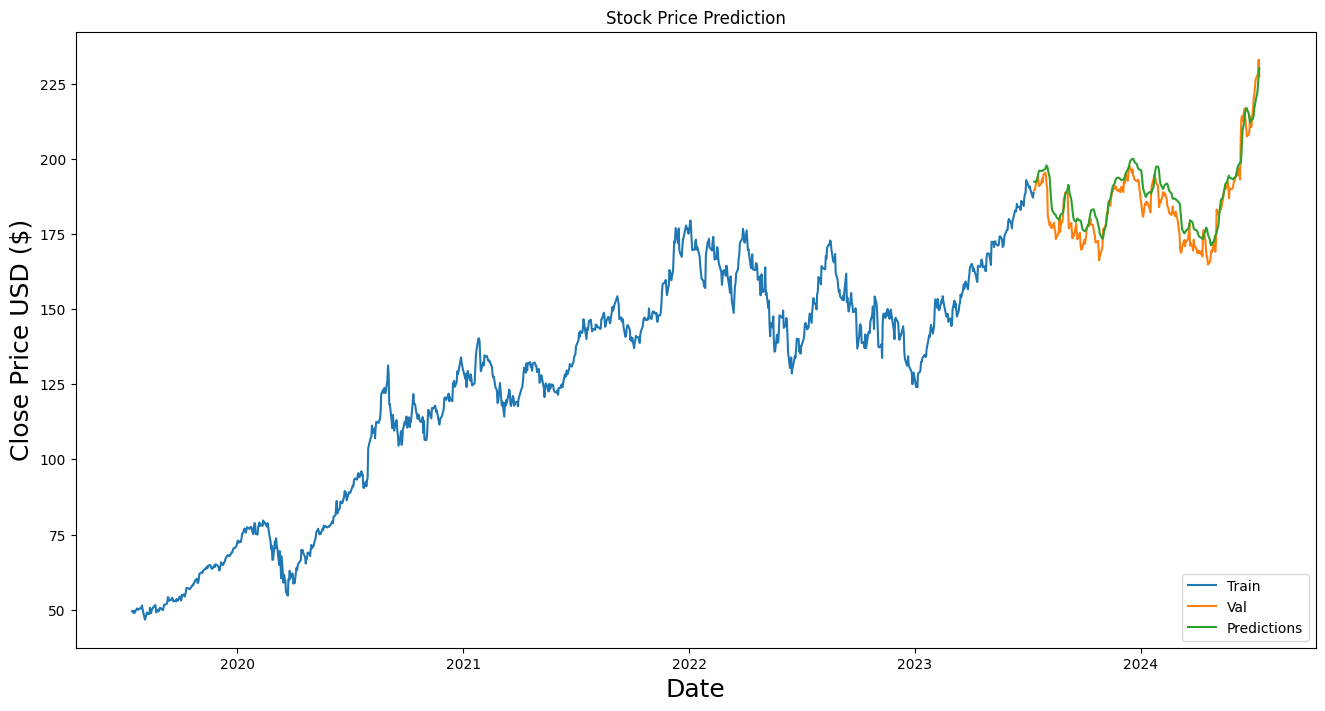

In [11]:
# Create training and testing datasets
train_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_data_len]
test_data = scaled_data[train_data_len - time_step:]  # Ensure to include time_step data for predictions

# Create the training datasets
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Calculate RMSE
rmse = np.sqrt(np.mean(((predictions - scaler.inverse_transform(y_test.reshape(-1, 1))) ** 2)))
print(f"RMSE: {rmse}")

# Adjust the valid DataFrame to match the length of predictions
valid = df[train_data_len:]
valid = valid[:len(predictions)]  # Ensure valid length matches predictions

valid['Predictions'] = predictions

# Plot the data
plt.figure(figsize=(16, 8))
plt.title('Stock Price Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

